## Demo: MultiContainer feeder example
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----


#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import numpy as np
import pandas as pd
import shapely.geometry

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
NR_BARGES = 3
TOTAL_AMOUNT = 100
BARGE_CAPACITY=10

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}


#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {"key": "MultiStoreHopper"},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "store_capacity": 4,
                  "nr_resources": 1,
                  "initials": [
                    {
                        "id": "Cargo type 1",
                        "level": TOTAL_AMOUNT,
                        "capacity": TOTAL_AMOUNT
                    },
                  ],
                 }
from_site = Site(**data_from_site)

location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "store_capacity": 4,
                "nr_resources": 1,
                "initials": [
                    {
                        "id": "Cargo type 1",
                        "level": 0,
                        "capacity": TOTAL_AMOUNT
                    },
                ],
                 }
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
vessels = {}
for i in range(NR_BARGES):
    vessels[f"vessel{i}"] = TransportProcessingResource(
        env=my_env,
        name=f"vessel{i}",
        geometry=location_from_site, 
        store_capacity=4,
        nr_resources=1,
        compute_v=lambda x: 10,
        initials=[
            {
                "id": "Cargo type 1",
                "level": 0,
                "capacity": BARGE_CAPACITY
            },
         ],
    )
    


# prepare input data for installer01
data_installer01 = {"env": my_env,
                 "name": "installer01",
                 "geometry": location_to_site, 
                 "store_capacity": 4,
                 "nr_resources": 1,
                 "compute_v": lambda x: 10,
                 "initials": [
                    {
                        "id": "Cargo type 1",
                        "level": 0,
                        "capacity": NR_BARGES, # Bug we need a watchtower for this
                    },
                 ],
                 }
# instantiate vessel_02 
installer01 = TransportProcessingResource(**data_installer01)

##### 3.3 Create activity/activities

In [6]:
processes = []
for i in range(NR_BARGES):
    vessel = vessels[f"vessel{i}"]
    requested_resources={}
    
    processes.append(
        model.WhileActivity(
            env=my_env,
            name=f"while {vessel.name}",
            registry=registry,
            sub_processes=[
                model.SequentialActivity(
                    env=my_env,
                    name=f"sequence {vessel.name}",
                    registry=registry,
                    sub_processes=[
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing empty {vessel.name}",
                            registry=registry,
                            mover=vessel,
                            destination=from_site,
                            duration=10,
                        ),
                        model.ShiftAmountActivity(
                            env=my_env,
                            name=f"load cargo type 1 {vessel.name}",
                            registry=registry,
                            processor=vessel,
                            origin=from_site,
                            destination=vessel,
                            amount=BARGE_CAPACITY,
                            duration=10,
                            id_="Cargo type 1",
                            requested_resources=requested_resources,
                        ),
                        model.MoveActivity(
                            env=my_env,
                            name=f"sailing filled {vessel.name}",
                            registry=registry,
                            mover=vessel,
                            destination=to_site,
                            duration=10,
                        ),
                        model.WhileActivity(
                            env=my_env,
                            name=f"unload cycle {vessel.name}",
                            registry=registry,
                            condition_event={
                                "type": "container", 
                                "concept": vessel, 
                                "state": "empty",
                                "id_":"Cargo type 1"
                            },
                            sub_processes=[
                                model.ShiftAmountActivity(
                                    env=my_env,
                                    name=f"unload cargo type 1 {vessel.name}",
                                    registry=registry,
                                    processor=installer01,
                                    origin=vessel,
                                    destination=installer01,
                                    amount=1,
                                    duration=10,
                                    id_="Cargo type 1",
                                    requested_resources=requested_resources,
                                    start_event={
                                        "type": "container", 
                                        "concept": installer01, 
                                        "state": "lt", 
                                        "level":1,
                                        "id_":"Cargo type 1"
                                    }
                                ),
                            ]
                        )
                    ],
                )
            ],
            condition_event={
                "type": "container", 
                "concept": from_site, 
                "state": "empty",
                "id_":"Cargo type 1_reservations"
            },
        )
    )

In [7]:
install_process = model.WhileActivity(
    env=my_env,
    name=f"While installer",
    registry=registry,
    condition_event={
        "type": "container", 
        "concept": to_site, 
        "state": "full",
        "id_":"Cargo type 1"
    },
    sub_processes=[
        model.ShiftAmountActivity(
            env=my_env,
            name=f"Install Cargo type 1",
            registry=registry,
            processor=installer01,
            origin=installer01,
            destination=to_site,
            amount=1,
            duration=2,
            id_="Cargo type 1",
            start_event={
                "type": "container", 
                "concept": installer01, 
                "state": "ge", 
                "level":1,
                "id_":"Cargo type 1"
            }
        )
    ],
)

#### 4. Register processes and run simpy

In [8]:
model.register_processes([install_process, *processes])
my_env.run()

In [9]:
def extend_id_map(activity, id_map):
    if hasattr(activity, "sub_processes"):
        for sub_process in activity.sub_processes:
            id_map = extend_id_map(sub_process, id_map)
    
    return {**id_map, activity.id: activity }

activity_map = {}
for activity in [*processes, install_process]:
    activity_map = extend_id_map(activity, activity_map)
    
id_map = {key:val.name for (key,val) in activity_map.items()}

#### 5. Inspect results
##### 5.1 Inspect logs

In [10]:
plot.get_log_dataframe(installer01, list(activity_map.values())).head()

,Activity,Timestamp,ActivityState,geometry,container level
0,unload cargo type 1 vessel2,1970-01-01 00:00:30,START,POINT (4.25222222 52.11428333),{'Cargo type 1': 0}
1,unload cargo type 1 vessel2,1970-01-01 00:00:40,STOP,POINT (4.25222222 52.11428333),{'Cargo type 1': 1}
2,unload cargo type 1 vessel1,1970-01-01 00:00:40,START,POINT (4.25222222 52.11428333),{'Cargo type 1': 1}
3,unload cargo type 1 vessel1,1970-01-01 00:00:50,STOP,POINT (4.25222222 52.11428333),{'Cargo type 1': 2}
4,Install Cargo type 1,1970-01-01 00:00:50,START,POINT (4.25222222 52.11428333),{'Cargo type 1': 2}


##### 5.2 Visualise gantt charts

In [11]:
acts = []
for proc in processes:
    acts.extend(proc.sub_processes[0].sub_processes)
    
plot.get_gantt_chart([*install_process.sub_processes, *acts])

In [12]:
plot.get_gantt_chart(
    [installer01], 
    id_map=id_map
)

##### 5.3 Visualise step charts

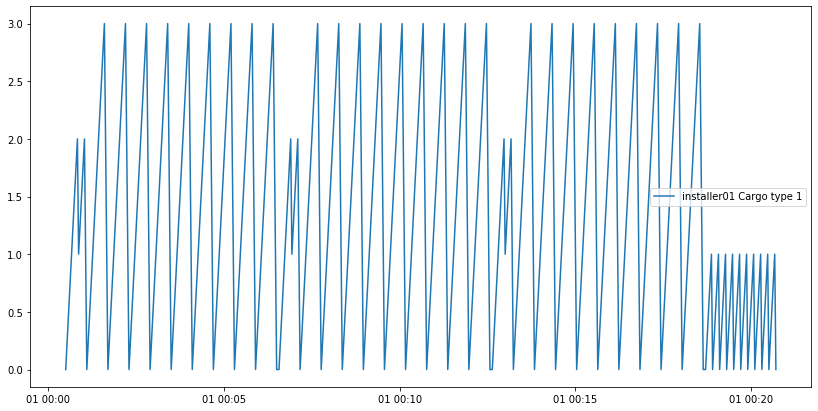

In [13]:
fig = plot.get_step_chart([installer01])

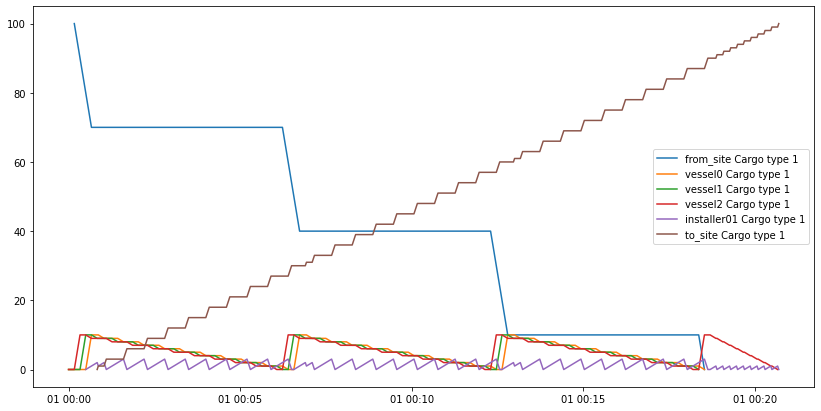

In [14]:
fig = plot.get_step_chart([from_site, *vessels.values(), installer01, to_site])